In [16]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import math

import sys 
sys.path.append('/Users/aleksandra/software/deCIBing/')
from help_functions import *

In [ ]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [3.0,2.0]

# Parameters 

In [3]:
# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
#'H0': 67.66,
'h': 0.6766,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06    
}


In [4]:
common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
    

'delta for galaxies' : "200c",
'delta for matter density' : "200c",
'delta for electron density':"200c",    

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'pk_nonlinear_for_vrms2' : 1,
'hm_consistency' : 1,
    
'f_free' : 1.0,

}


In [5]:
#### CIB
websky_cib_pdict = {}
websky_cib_pdict['Redshift evolution of dust temperature' ] =  0.2
websky_cib_pdict['Dust temperature today in Kelvins' ] = 20.7
websky_cib_pdict['Emissivity index of sed' ] = 1.6
websky_cib_pdict['Power law index of SED at high frequency' ] = 1.7 # not given in WebSky paper actually not relevant since we dont use high freqs in websky.
websky_cib_pdict['Redshift evolution of L − M normalisation' ] = 1.28
websky_cib_pdict['Most efficient halo mass in Msun' ] = pow(10.,12.3)
websky_cib_pdict['Normalisation of L − M relation in [Jy MPc2/Msun]' ] =  4.461102571695613e-07 # L0_websky, not given in WebSky paper
websky_cib_pdict['Size of of halo masses sourcing CIB emission' ] = 0.3
websky_cib_pdict['z_plateau_cib' ] = 2.

# M_min_HOD_cib is the threshold above which nc = 1
websky_cib_pdict['M_min_HOD_cib' ] = pow(10.,10.1) #is ignored
websky_cib_pdict['M_min_subhalo_in_Msun' ] = 1.0e11 # if M_min_subhalo_in_Msun is given, then M_min_HOD_cib is ignored
websky_cib_pdict['use_nc_1_for_all_halos_cib_HOD'] = 1
websky_cib_pdict['sub_halo_mass_function' ] = 'JvdB14'
#Mass bounds
websky_cib_pdict['use_redshift_dependent_M_min'] = 1
websky_cib_pdict['full_path_to_redshift_dependent_M_min'] = "/Users/aleksandra/software/class_sz/sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt"
#websky_cib_pdict['M_min_cib' ] = 1e8*p18_pdict['h']
websky_cib_pdict['M_max_cib' ] = 1e16*cosmo_params['h']

#for the monopole computation, is it necessary ??
websky_cib_pdict['freq_min'] = 2e1
websky_cib_pdict['freq_max'] = 4e3
websky_cib_pdict['dlogfreq' ] = 0.05

# Select frequencies 

In [6]:
nu_list = 217,353,545
nu_list_str = '217,353,545'

## Flux cut 

In [7]:
# flux cut values

cib_flux = {}
# Planck flux cut, Table 1 in https://arxiv.org/pdf/1309.0382.pdf
cib_flux['100'] = 400
cib_flux['143'] = 350
cib_flux['217'] = 225
cib_flux['353'] = 315
cib_flux['545'] = 350
cib_flux['857'] = 710
cib_flux['3000'] = 1000
#SO, from SO foreacst
cib_flux['93'] = 7
cib_flux['145'] = 15
cib_flux['225'] = 20
cib_flux['280'] = 25
#CCAT prime, McCarthy et al.'s' assumptions
# cib_flux['93'] = 400
# cib_flux['145'] = 350
# cib_flux['225'] = 225
# cib_flux['220'] = 225
# cib_flux['280'] = 225
# cib_flux['350'] = 315
# cib_flux['550'] = 350
# cib_flux['545'] = 350
# cib_flux['850'] = 710

def make_flux_cut_list(cib_flux_dict, nu_list):
    """
    Make a string of flux cut values for given frequency list to pass into class_sz
    Beware: if frequency not in the flux_cut dictionary, it assigns 0
    """
    cib_flux_list = []
    keys = list(cib_flux.keys())
    for i,nu in enumerate(nu_list):
        if str(nu) in keys:
            cib_flux_list.append(cib_flux[str(nu)])
        else:
            cib_flux_list.append(0)
    return cib_flux_list

cib_flux_list = make_flux_cut_list(cib_flux, nu_list)
cib_flux_list

[225, 315, 350]

# Compute CIB auto 

In [17]:
#Planck 2014/ McCarthy et al. 
N = Class()
N.set(common_params)
N.set(cosmo_params)
N.set(websky_cib_pdict)

N.set({# class_sz parameters:
        'output':'cib_cib_1h,cib_cib_2h,dcib0dz',
        'class_sz_verbose':0,
        
        'cib_frequency_list_num' : len(nu_list),
        'cib_frequency_list_in_GHz' : nu_list_str,  
        'cib_Snu_cutoff_list [mJy]': str(list(cib_flux_list))[1:-1],
        'has_cib_flux_cut': 1
        })
        
N.compute()

In [18]:
cib = N.cl_cib_cib()

# cib_1h = np.asarray(cib[str(nu_list[0])+'x'+str(nu_list[0])]['1h']) 
# cib_2h = np.asarray(cib[str(nu_list[0])+'x'+str(nu_list[0])]['2h'])
ell_cib = np.asarray(cib[str(nu_list[0])+'x'+str(nu_list[0])]['ell'])

cl2dl = ell_cib*(ell_cib+1)/2/np.pi

# Compare with data

In [19]:
path_ps = "/Users/aleksandra/software/class_sz/sz_auxiliary_files/cib_files/"

# # in MJy2/sr
ell_ws, ws_cib145 = np.loadtxt(path_ps+"cl_cib_cib_145_websky_l_cl_090322.txt").T
ell_ws, ws_cib217 = np.loadtxt(path_ps+"cl_cib_cib_217_websky_l_cl_090322.txt").T
ell_ws, ws_cib353 = np.loadtxt(path_ps+"cl_cib_cib_353_websky_l_cl_090322.txt").T
ell_ws, ws_cib545 = np.loadtxt(path_ps+"cl_cib_cib_545_websky_l_cl_090322.txt").T

path_ps = "/Users/aleksandra/software/deCIBing/benchmarks/websky_measurements/"
ell_ws, ws_cib217 = np.loadtxt(path_ps+"websky_cib217_anafast_Jysr_nside4096.txt")
ell_ws, ws_cib353 = np.loadtxt(path_ps+"websky_cib353_anafast_Jysr_nside4096.txt")
ell_ws, ws_cib545 = np.loadtxt(path_ps+"websky_cib545_anafast_Jysr_nside4096.txt")
pixwin = np.loadtxt("/Users/aleksandra/software/deCIBing/benchmarks/websky_measurements/pixwin_hp_nside4096.txt")

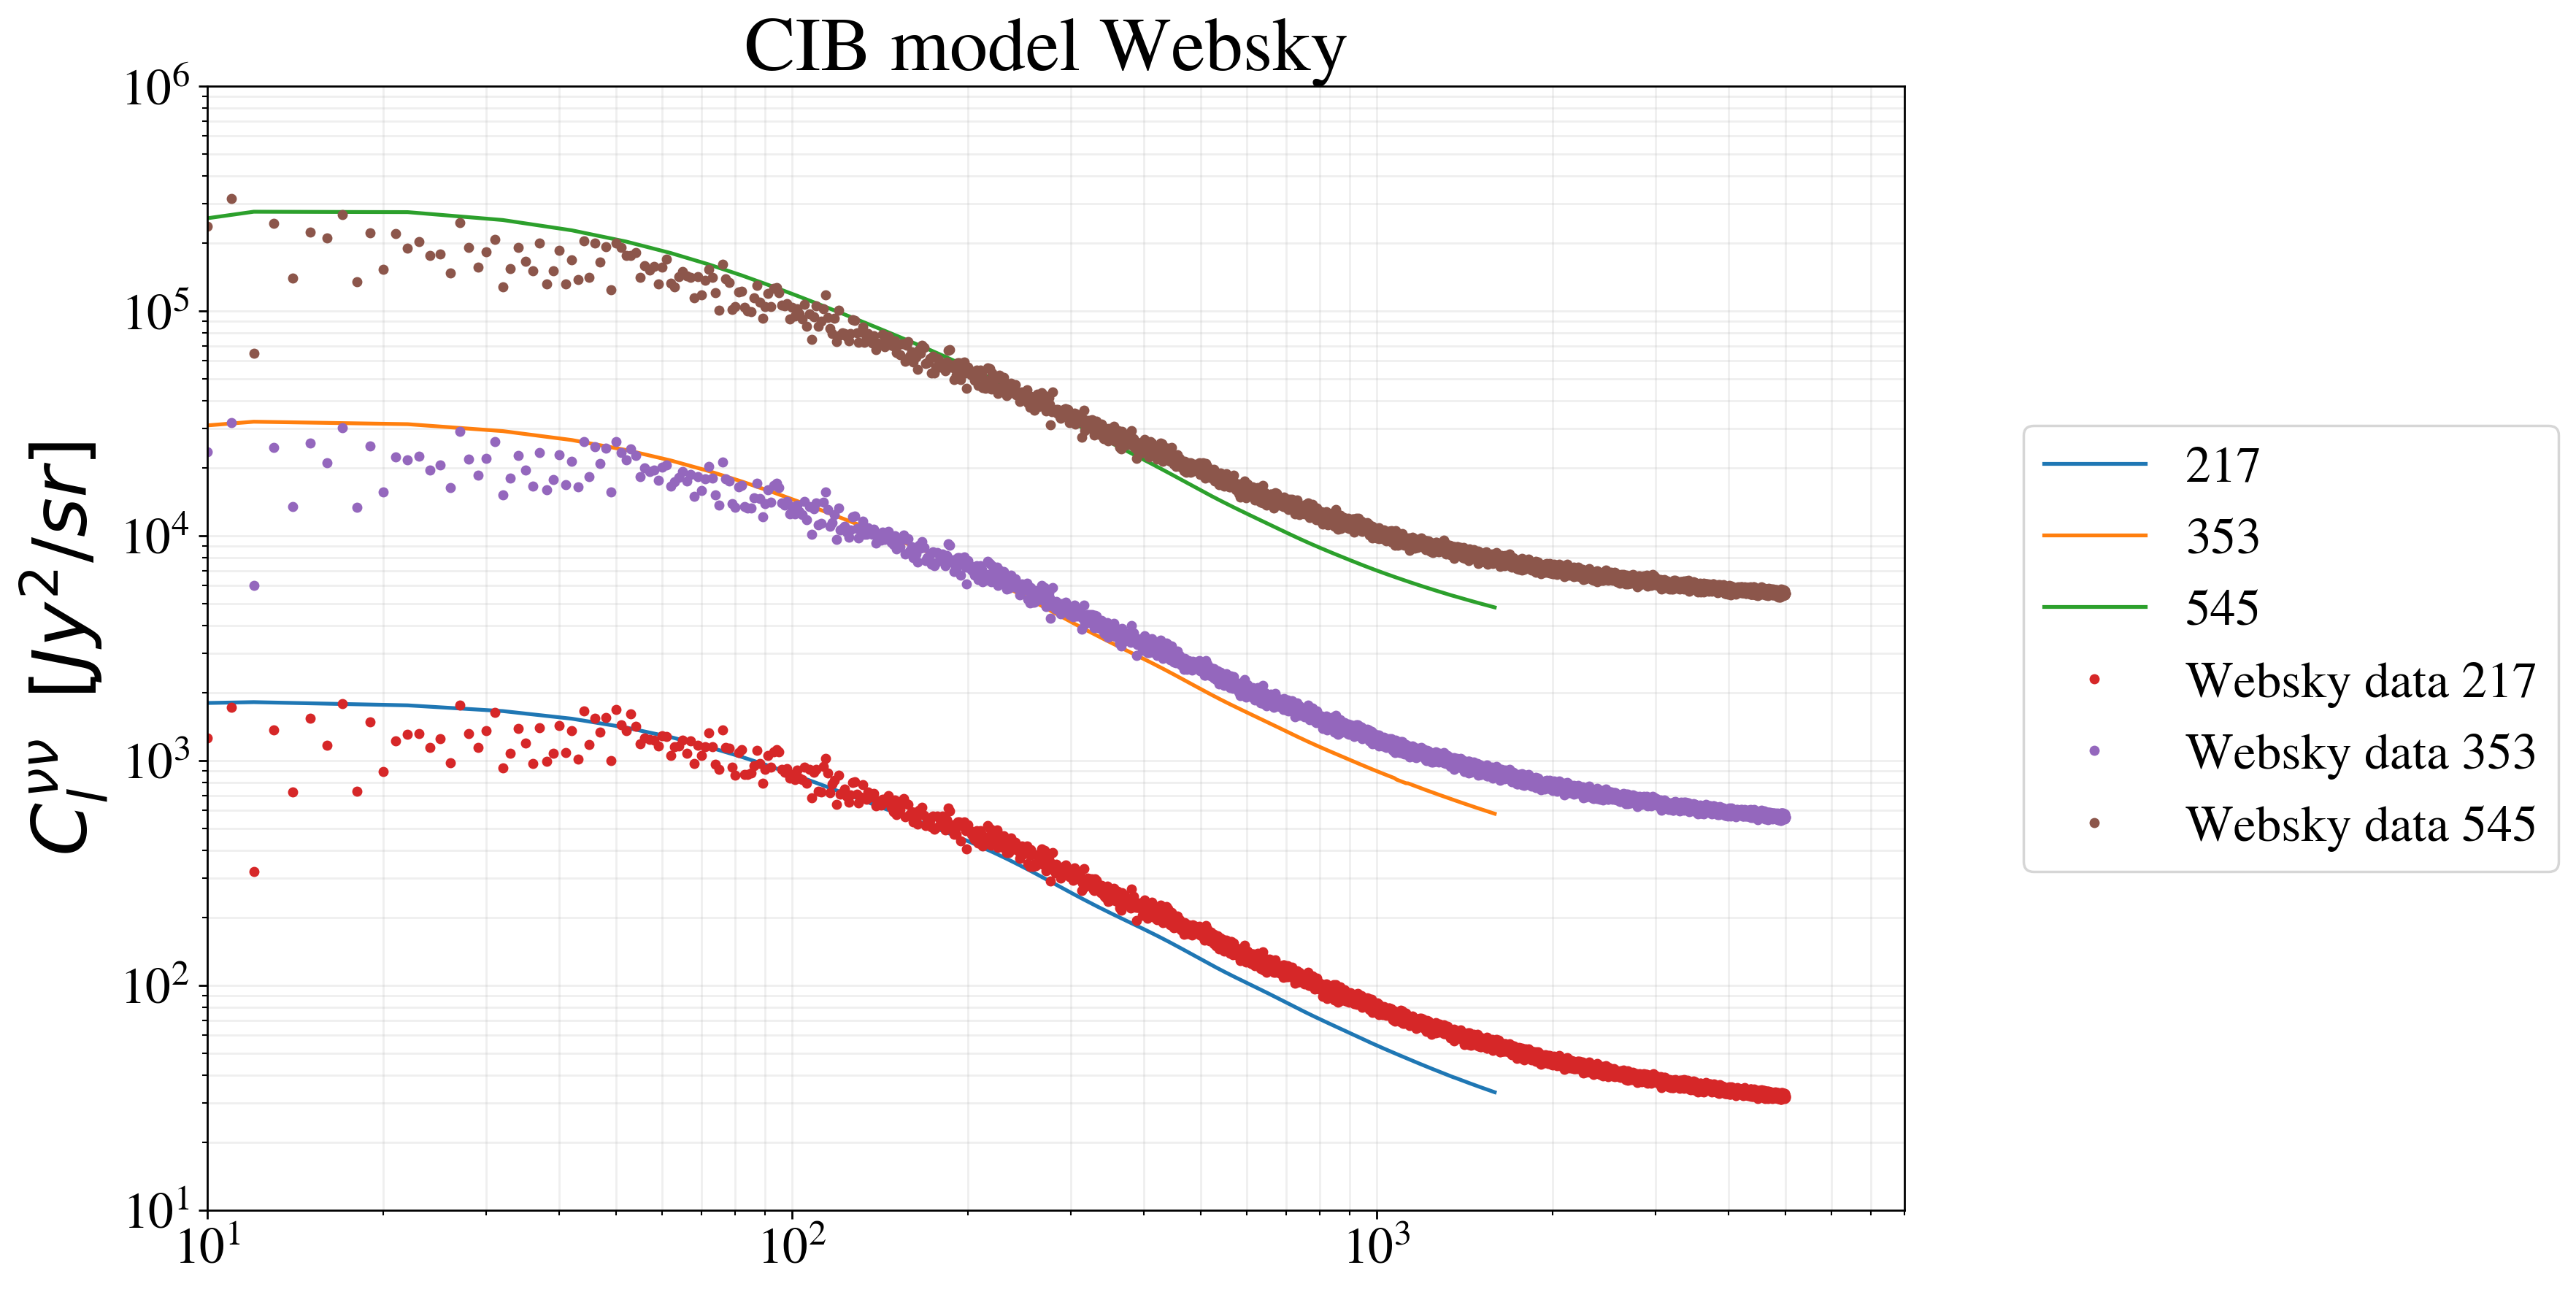

In [20]:
plt.figure(figsize=(12,8), dpi=250)
plt.ylabel(r"$C_l^{\nu \nu} \,\,\, [Jy^2/sr]$", size=30)
plt.title('CIB model Websky ', fontsize=30)


for (i,nu) in enumerate(nu_list):
    #CIB websky
    cib_1h = np.asarray(cib[str(nu)+'x'+str(nu)]['1h']) 
    cib_2h = np.asarray(cib[str(nu)+'x'+str(nu)]['2h'])
    shot_noise = cib_sn[str(nu)][str(nu)+'x'+str(nu)] / Jysr_to_uKcmb(nu)/ Jysr_to_uKcmb(nu)
    plt.plot(ell_cib, (cib_1h+cib_2h)/cl2dl + shot_noise, "-", label=r'%.1i'%(nu))
    
plt.plot(ell_ws, 1e12*ws_cib217, ".", label = "Websky data 217")
plt.plot(ell_ws, 1e12*ws_cib353, ".", label = "Websky data 353")
plt.plot(ell_ws, 1e12*ws_cib545, ".", label = "Websky data 545")

plt.xlim(1.e1, 8.e3)
plt.ylim(1e1,1e6) 
plt.yscale("log")
plt.xscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(which='both',alpha=0.2)
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5), fontsize=20)

